In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.layouts import gridplot
from autoviz.AutoViz_Class import AutoViz_Class
from matplotlib.backends.backend_pdf import PdfPages
import joblib
import pickle
%matplotlib inline

Imported v0.1.904. Please call AutoViz in this sequence:
    AV = AutoViz_Class()
    %matplotlib inline
    dfte = AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=1, lowess=False,
               chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30, save_plot_dir=None)


# Basic EDA functions

In [2]:

def calculate_missing_percentages(dataframe):
    """
    Calculate the percentage of missing values per column in a DataFrame.

    Parameters:
    dataframe (pandas.DataFrame): The DataFrame to analyze.

    Returns:
    pandas.Series: A Series containing the percentage of missing values per column.
    """
    missing_percentages = dataframe.isna().mean() * 100
    return missing_percentages

def drop_columns_with_high_missing_percentages(dataframe, threshold=10):
    """
    Drop columns from DataFrame where missing values exceed the specified threshold.

    Parameters:
    dataframe (pandas.DataFrame): The DataFrame to analyze.
    threshold (float): The threshold percentage of missing values. Default is 10.

    Returns:
    pandas.DataFrame: DataFrame with columns dropped based on the specified threshold.
    """
    missing_percentages = calculate_missing_percentages(dataframe)
    columns_to_drop = missing_percentages[missing_percentages > threshold].index
    dataframe_dropped = dataframe.drop(columns=columns_to_drop)
    return dataframe_dropped

In [3]:
os.chdir(r'C:\Users\YKoyama\OneDrive - Carollo Engineers\General - NAWI 3.13 RO Modeling\Data Request\EDA and Modeling')

# Load 30-min data from pkl

In [4]:
# Load pickle file back into memory
# Specify the pickle file name
pickle_file = 'formatted_raw_30_min_data.pkl'
with open(pickle_file, 'rb') as f:
    df_30min_dict = pickle.load(f)

In [5]:
df_30min_dict.keys()

dict_keys(['FEED', 'ROF', 'C02', 'E01', 'H02'])

# Process 30-min data

## Get number of hours on perday per unit

In [6]:
# create number of hours per day operating 
def sum_hours_above_threshold(df, value_column, threshold=300):
    # Step 1: Filter the DataFrame
    filtered_df = df[df[value_column] >= threshold].copy()  # Create a copy to avoid modifying original DataFrame
    
    # Step 2: Calculate number of hours for each row
    filtered_df['hours'] = filtered_df.index.to_series().diff().dt.total_seconds().fillna(0) / 3600.0
    
    # Step 3: Aggregate by day and sum the hours
    daily_summary = filtered_df.groupby(filtered_df.index.date)['hours'].sum().reset_index()
    
    # Step 4: Create a new DataFrame with the results
    result_df = daily_summary.rename(columns={'index':'Date', 'hours':'Hours Above Threshold'})
    result_df['Date'] = pd.to_datetime(result_df['Date'])  # Convert Date column to datetime
    result_df = result_df.set_index('Date')
    return result_df


<Axes: xlabel='Timestamp'>

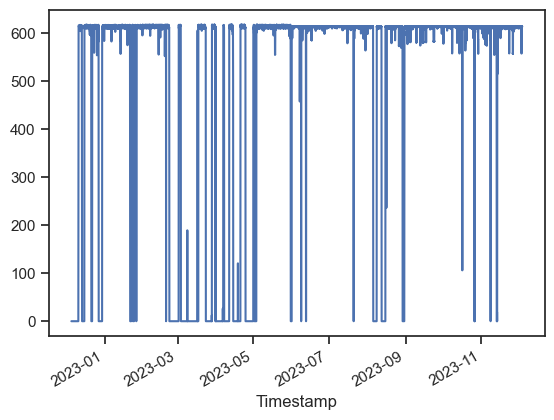

In [7]:
df_30min_dict['C02']['Concentrate flow'].plot()

In [8]:
C02_hours_on = sum_hours_above_threshold(df_30min_dict['C02'],value_column='Concentrate flow', threshold=600 )
C02_hours_on.rename(columns={'Hours Above Threshold':'C02 Hours On'}, inplace=True)
#C02_hours_on.head()
E01_hours_on = sum_hours_above_threshold(df_30min_dict['E01'],value_column='Concentrate flow', threshold=600 )
E01_hours_on.rename(columns={'Hours Above Threshold':'E01 Hours On'}, inplace=True)
#E01_hours_on.head()
H02_hours_on = sum_hours_above_threshold(df_30min_dict['H02'],value_column='Concentrate flow', threshold=600 )
H02_hours_on.rename(columns={'Hours Above Threshold':'H02 Hours On'}, inplace=True)
H02_hours_on.head()

,H02 Hours On
Date,
2022-12-06,15.5
2022-12-07,11.0
2022-12-08,37.0
2022-12-09,24.0
2022-12-10,24.0


<Axes: xlabel='Timestamp'>

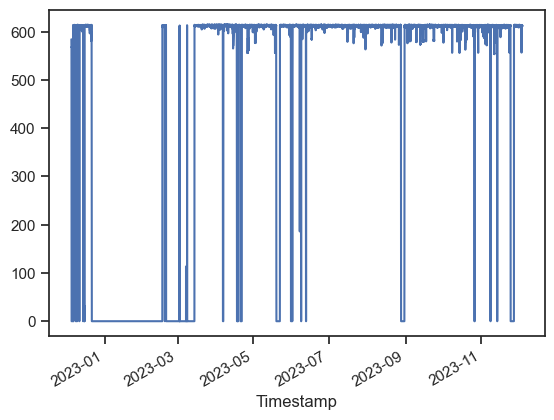

In [9]:
df_30min_dict['H02']['Concentrate flow'].plot()

In [10]:
combined_hrs_on = pd.concat([E01_hours_on, C02_hours_on, H02_hours_on], axis=1)
combined_hrs_on.head(10) 

,E01 Hours On,C02 Hours On,H02 Hours On
Date,,,
2022-12-05,7.5,NaN,NaN
2022-12-06,24.0,NaN,15.5
2022-12-07,11.0,NaN,11.0
2022-12-08,37.0,NaN,37.0
2022-12-09,24.0,NaN,24.0
2022-12-10,24.0,7.5,24.0
2022-12-11,24.0,24.0,24.0
2022-12-12,24.0,24.0,24.0
2022-12-13,24.0,11.5,24.0


In [12]:
df_30min_dict['ROF'].columns

Index(['level_1', 'NH3', 'NTU', 'EC', 'ROF TOC', 'Cl2', 'pH', 'Temp (degF)',
       'TOC', 'Concentrate  EC', 'Stage 1-2  EC', 'Stage 2-3  EC',
       'Perm Stage 1  EC', 'Perm Stage 2  EC ', 'Perm Stage 3  EC',
       'Stage 1 %removal', 'Stage 2  %removal', 'Stage 3 %removal',
       'Unit AFBC %removal', 'Permeate flow', 'Concentrate flow',
       'Stage 2 Perm flow', 'Stage 3 Perm flow'],
      dtype='object')

In [207]:
# save as pkl

# Specify the pickle file name
pickle_file = 'daily_hours_on_data.pkl'

# Export dictionary of DataFrames as a pickle file
with open(pickle_file, 'wb') as f:
    pickle.dump(combined_hrs_on, f)

# Specify the pickle file name
pickle_file = 'df_30min_wq_dict.pkl'

# Export dictionary of DataFrames as a pickle file
with open(pickle_file, 'wb') as f:
    pickle.dump(df_30min_wq_dict, f)

In [13]:
df_30min_wq_dict={}
for i in df_30min_dict.keys():
    df_30min_wq_dict[i] = df_30min_dict[i][['NH3', 'NTU', 'EC', 'ROF TOC', 'Cl2', 'pH', 'Temp (degF)',
       'TOC', 'Concentrate  EC', 'Stage 1-2  EC', 'Stage 2-3  EC']]

# Create day of the year variable from date

In [14]:
# get date from timestamp and then convert to day of the year
def add_day_of_year_column(df):
    # Ensure index is datetime
    df.index = pd.to_datetime(df.index)
    
    # Add a new column 'DayOfYear' with day of the year
    df['DayOfYear'] = df.index.dayofyear
    
    return df

In [15]:
combined_hrs_on_day_of_year = add_day_of_year_column(combined_hrs_on)
combined_hrs_on_day_of_year.head()

,E01 Hours On,C02 Hours On,H02 Hours On,DayOfYear
Date,,,,
2022-12-05,7.5,NaN,NaN,339
2022-12-06,24.0,NaN,15.5,340
2022-12-07,11.0,NaN,11.0,341
2022-12-08,37.0,NaN,37.0,342
2022-12-09,24.0,NaN,24.0,343


# Convert weekly WQ to daily WQ by using the nearest date 

In [209]:
# Load pickle file back into memory
# Specify the pickle file name
pickle_file = 'formatted_grab_WQ_data.pkl'
with open(pickle_file, 'rb') as f:
    grab_df_dict = pickle.load(f)

In [210]:
# Concatenate all DataFrames based on index
grab_wq = pd.concat(grab_df_dict.values(), axis=1)
grab_wq.describe()

,GWRS-ROF_Alkalinity (CaCO3)_mg/L,GWRS-ROP_Alkalinity (CaCO3)_mg/L,GWRS-ROC_SiO2_mg/L,GWRS-ROF_SiO2_mg/L,GWRS-ROP_SiO2_mg/L,GWRS-Q1_F_mg/L,GWRS-ROF_Cl_mg/L,GWRS-ROP_Cl_mg/L,GWRS-ROC_Na_mg/L,GWRS-ROF_Na_mg/L,GWRS-ROP_Na_mg/L,GWRS-ROC_K_mg/L,GWRS-ROF_K_mg/L,GWRS-ROP_K_mg/L,GWRS-ROC_Mg_mg/L,GWRS-ROF_Mg_mg/L,GWRS-ROP_Mg_mg/L,GWRS-ROC_Ca_mg/L,GWRS-ROF_Ca_mg/L,GWRS-ROP_Ca_mg/L,GWRS-Q1_Sr_ug/L,GWRS-ROC_Cu_ug/L,GWRS-ROF_Cu_ug/L,GWRS-ROP_Cu_ug/L,GWRS-ROC_Fe_ug/L,GWRS-ROF_Fe_ug/L,GWRS-ROP_Fe_ug/L,GWRS-ROC_PO4-P_mg/L,GWRS-Q1_Total Nitrogen_mg/L,GWRS-ROP_NO2-N_mg/L,GWRS-ROF_NO3-N_mg/L,GWRS-ROP_NO3-N_mg/L
count,12.00,12.000000,12.000000,12.000000,1.200000e+01,27.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,1.200000e+01,12.000000,12.000000,1.200000e+01,15.000000,14.000000,12.000000,12.000000,12.000000,12.000000,12.0,51.000000,50.00000,5.300000e+01,1.00,55.000000
mean,201.50,9.033333,120.983333,19.225000,1.000000e-01,0.831481,382.750000,7.566667,1793.333333,272.916667,8.225000,139.416667,21.141667,0.487500,241.083333,36.025000,5.000000e-02,532.166667,81.108333,5.000000e-02,872.400000,36.214286,9.991667,0.283333,637.333333,98.058333,0.5,3.019020,14.90600,2.000000e-04,5.74,0.771636
std,17.00,1.584776,14.913193,1.174831,1.449488e-17,0.063167,111.564189,2.596618,406.298890,52.255419,1.994139,14.247541,1.879777,0.273965,47.146692,6.312056,7.247438e-18,25.001212,3.415062,7.247438e-18,170.270289,13.884904,3.708579,0.428174,54.155220,7.018088,0.0,1.165988,3.21574,2.736444e-20,NaN,0.191502
min,173.00,7.200000,94.800000,17.100000,1.000000e-01,0.690000,232.000000,3.900000,1260.000000,202.000000,4.700000,122.000000,18.300000,0.050000,169.000000,24.500000,5.000000e-02,489.000000,73.100000,5.000000e-02,693.000000,18.900000,5.200000,0.100000,557.000000,82.600000,0.5,1.000000,7.50000,2.000000e-04,5.74,0.400000
25%,189.50,7.450000,113.000000,18.650000,1.000000e-01,0.790000,252.500000,5.075000,1350.000000,218.500000,6.650000,127.500000,19.700000,0.387500,192.750000,29.600000,5.000000e-02,521.000000,80.700000,5.000000e-02,736.000000,25.625000,7.225000,0.100000,598.500000,93.800000,0.5,2.315000,13.02500,2.000000e-04,5.74,0.615000
50%,205.50,9.150000,119.500000,19.500000,1.000000e-01,0.820000,419.000000,7.950000,1880.000000,282.500000,8.350000,137.000000,21.250000,0.600000,253.500000,38.300000,5.000000e-02,527.500000,81.650000,5.000000e-02,807.000000,35.950000,10.250000,0.100000,636.500000,98.350000,0.5,2.990000,14.65000,2.000000e-04,5.74,0.780000
75%,210.25,9.825000,128.000000,20.125000,1.000000e-01,0.875000,473.250000,9.275000,2020.000000,320.250000,9.525000,149.500000,23.025000,0.625000,269.000000,41.150000,5.000000e-02,545.500000,82.200000,5.000000e-02,963.000000,42.950000,11.400000,0.100000,672.750000,103.250000,0.5,3.655000,16.30000,2.000000e-04,5.74,0.915000
max,232.00,12.100000,150.000000,20.600000,1.000000e-01,0.980000,527.000000,11.300000,2510.000000,342.000000,11.400000,162.000000,23.500000,0.800000,308.000000,42.200000,5.000000e-02,591.000000,85.900000,5.000000e-02,1160.000000,64.000000,19.100000,1.200000,734.000000,107.000000,0.5,8.530000,22.90000,2.000000e-04,5.74,1.130000


In [211]:
grab_wq.head(3)

,GWRS-ROF_Alkalinity (CaCO3)_mg/L,GWRS-ROP_Alkalinity (CaCO3)_mg/L,GWRS-ROC_SiO2_mg/L,GWRS-ROF_SiO2_mg/L,GWRS-ROP_SiO2_mg/L,GWRS-Q1_F_mg/L,GWRS-ROF_Cl_mg/L,GWRS-ROP_Cl_mg/L,GWRS-ROC_SO4_mg/L,GWRS-ROF_SO4_mg/L,GWRS-ROP_SO4_mg/L,GWRS-ROC_Na_mg/L,GWRS-ROF_Na_mg/L,GWRS-ROP_Na_mg/L,GWRS-ROC_K_mg/L,GWRS-ROF_K_mg/L,GWRS-ROP_K_mg/L,GWRS-ROC_Mg_mg/L,GWRS-ROF_Mg_mg/L,GWRS-ROP_Mg_mg/L,GWRS-ROC_Ca_mg/L,GWRS-ROF_Ca_mg/L,GWRS-ROP_Ca_mg/L,GWRS-Q1_Sr_ug/L,GWRS-ROC_Cu_ug/L,GWRS-ROF_Cu_ug/L,GWRS-ROP_Cu_ug/L,GWRS-ROC_Fe_ug/L,GWRS-ROF_Fe_ug/L,GWRS-ROP_Fe_ug/L,GWRS-ROC_PO4-P_mg/L,GWRS-Q1_Total Nitrogen_mg/L,GWRS-ROP_NO2-N_mg/L,GWRS-ROF_NO3-N_mg/L,GWRS-ROP_NO3-N_mg/L
DATETIME,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-12-14 06:00:00,209.0,10.8,113.0,18.2,0.1,NaN,527.0,11.3,NaN,231,0.05,2510.0,342.0,10.7,160.0,23.2,0.60,296.0,42.2,0.05,532.0,80.8,0.05,NaN,38.1,7.4,0.1,693.0,103.0,0.5,2.06,13.8,NaN,NaN,NaN
2023-01-11 06:00:00,204.0,8.3,107.0,17.1,0.1,NaN,398.0,7.6,1410,218,0.05,1800.0,263.0,7.4,131.0,19.4,0.05,245.0,36.8,0.05,521.0,76.6,0.05,NaN,34.3,6.7,0.1,557.0,82.6,0.5,2.37,13.0,NaN,NaN,NaN
2023-02-08 06:00:00,232.0,10.5,127.0,19.5,0.1,0.79,449.0,8.3,1550,237,0.05,2050.0,306.0,8.9,149.0,22.3,0.50,278.0,40.9,0.05,550.0,84.9,0.05,1160.0,60.0,9.7,1.2,648.0,104.0,0.5,3.67,NaN,NaN,NaN,NaN


In [212]:
combined_hrs_on_day_of_year.sort_index(inplace=True)
grab_wq.sort_index(inplace=True)
#grab_wq.index=grab_wq.index.date
#grab_wq.index=pd.to_datetime(grab_wq.index)
grab_wq=grab_wq.astype(float)
combined_hrs_on_day_of_year=combined_hrs_on_day_of_year.astype(float)
combined_hrs_on_day_of_year.dtypes, grab_wq.dtypes

(E01 Hours On    float64
 C02 Hours On    float64
 H02 Hours On    float64
 DayOfYear       float64
 dtype: object,
 GWRS-ROF_Alkalinity (CaCO3)_mg/L    float64
 GWRS-ROP_Alkalinity (CaCO3)_mg/L    float64
 GWRS-ROC_SiO2_mg/L                  float64
 GWRS-ROF_SiO2_mg/L                  float64
 GWRS-ROP_SiO2_mg/L                  float64
 GWRS-Q1_F_mg/L                      float64
 GWRS-ROF_Cl_mg/L                    float64
 GWRS-ROP_Cl_mg/L                    float64
 GWRS-ROC_SO4_mg/L                   float64
 GWRS-ROF_SO4_mg/L                   float64
 GWRS-ROP_SO4_mg/L                   float64
 GWRS-ROC_Na_mg/L                    float64
 GWRS-ROF_Na_mg/L                    float64
 GWRS-ROP_Na_mg/L                    float64
 GWRS-ROC_K_mg/L                     float64
 GWRS-ROF_K_mg/L                     float64
 GWRS-ROP_K_mg/L                     float64
 GWRS-ROC_Mg_mg/L                    float64
 GWRS-ROF_Mg_mg/L                    float64
 GWRS-ROP_Mg_mg/L            

In [213]:
# Function to merge based on closest timestamp
def merge_closest_timestamps(daily_df, weekly_monthly_df):
    # Initialize an empty DataFrame to store merged data
    merged_df = pd.DataFrame(index=daily_df.index.copy())  # Initialize with daily_df index

    for col in weekly_monthly_df.columns:
        merged_data = []
        temp = weekly_monthly_df[[col]].dropna()
        for index, row in daily_df.iterrows():
            closest_idx = pd.DataFrame(abs(temp.index - index),temp.index).idxmin()  # Find index of closest timestamp
            
            # Get non-NA value from weekly_monthly_df for the current column
            non_na_value = temp.loc[closest_idx, col].values[0]
            
            # Create a dictionary with daily_df data and non-NA value for the current column
            merged_row = {**row.to_dict(), col: non_na_value}
            merged_data.append(merged_row)
        # Convert merged_data into a DataFrame and set index to match daily_df
        merged_col_df = pd.DataFrame(merged_data, index=daily_df.index)
        
        # Concatenate the current column's merged data to the overall merged_df
        merged_df = pd.concat([merged_df, merged_col_df[col]], axis=1)   
    merged_df = pd.concat([daily_df, merged_df ], axis=1)
    return merged_df

In [214]:
# combined_hrs_on_day_of_year_grab_wq = pd.merge_asof(combined_hrs_on_day_of_year, grab_wq,
#  left_index=True, right_index=True, direction='nearest')
combined_hrs_on_day_of_year_grab_wq=merge_closest_timestamps(combined_hrs_on_day_of_year, grab_wq)
combined_hrs_on_day_of_year_grab_wq.head(3)


,E01 Hours On,C02 Hours On,H02 Hours On,DayOfYear,GWRS-ROF_Alkalinity (CaCO3)_mg/L,GWRS-ROP_Alkalinity (CaCO3)_mg/L,GWRS-ROC_SiO2_mg/L,GWRS-ROF_SiO2_mg/L,GWRS-ROP_SiO2_mg/L,GWRS-Q1_F_mg/L,GWRS-ROF_Cl_mg/L,GWRS-ROP_Cl_mg/L,GWRS-ROC_SO4_mg/L,GWRS-ROF_SO4_mg/L,GWRS-ROP_SO4_mg/L,GWRS-ROC_Na_mg/L,GWRS-ROF_Na_mg/L,GWRS-ROP_Na_mg/L,GWRS-ROC_K_mg/L,GWRS-ROF_K_mg/L,GWRS-ROP_K_mg/L,GWRS-ROC_Mg_mg/L,GWRS-ROF_Mg_mg/L,GWRS-ROP_Mg_mg/L,GWRS-ROC_Ca_mg/L,GWRS-ROF_Ca_mg/L,GWRS-ROP_Ca_mg/L,GWRS-Q1_Sr_ug/L,GWRS-ROC_Cu_ug/L,GWRS-ROF_Cu_ug/L,GWRS-ROP_Cu_ug/L,GWRS-ROC_Fe_ug/L,GWRS-ROF_Fe_ug/L,GWRS-ROP_Fe_ug/L,GWRS-ROC_PO4-P_mg/L,GWRS-Q1_Total Nitrogen_mg/L,GWRS-ROP_NO2-N_mg/L,GWRS-ROF_NO3-N_mg/L,GWRS-ROP_NO3-N_mg/L
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-12-05,7.5,NaN,NaN,339.0,209.0,10.8,113.0,18.2,0.1,0.88,527.0,11.3,1410.0,231.0,0.05,2510.0,342.0,10.7,160.0,23.2,0.6,296.0,42.2,0.05,532.0,80.8,0.05,922.0,38.1,7.4,0.1,693.0,103.0,0.5,2.6,12.5,0.0002,5.74,0.91
2022-12-06,24.0,NaN,15.5,340.0,209.0,10.8,113.0,18.2,0.1,0.88,527.0,11.3,1410.0,231.0,0.05,2510.0,342.0,10.7,160.0,23.2,0.6,296.0,42.2,0.05,532.0,80.8,0.05,922.0,38.1,7.4,0.1,693.0,103.0,0.5,2.6,12.5,0.0002,5.74,0.91
2022-12-07,11.0,NaN,11.0,341.0,209.0,10.8,113.0,18.2,0.1,0.88,527.0,11.3,1410.0,231.0,0.05,2510.0,342.0,10.7,160.0,23.2,0.6,296.0,42.2,0.05,532.0,80.8,0.05,922.0,38.1,7.4,0.1,693.0,103.0,0.5,2.6,12.5,0.0002,5.74,0.91


In [215]:
# Specify the pickle file name
pickle_file = 'combined_hrs_on_day_of_year_grab_wq.pkl'

# Export dictionary of DataFrames as a pickle file
with open(pickle_file, 'wb') as f:
    pickle.dump(combined_hrs_on_day_of_year_grab_wq, f)

# Merge additionally crated daily columns with existing SPI data

In [247]:
# Specify the pickle file name
pickle_file = 'SPI_daily_data.pkl'

# Export dictionary of DataFrames as a pickle file
with open(pickle_file, 'rb') as f:
    SPI_df_dict = pickle.load(f)

# Get date range within research scope
SPI_filtered_df = {}
for k in SPI_df_dict.keys():
    SPI_filtered_df[k] = SPI_df_dict[k].iloc[SPI_df_dict[k].index.get_loc("2022-12-10"):SPI_df_dict[k].index.get_loc("2023-12-03") + 1]
for i in SPI_filtered_df.keys():
    SPI_filtered_df[i] = SPI_filtered_df[i].join(combined_hrs_on_day_of_year_grab_wq, how='left')
    SPI_filtered_df[i] = SPI_filtered_df[i].sort_index()

## merge 30min wq dt

In [263]:
df_30min_wq_dict={}
for i in df_30min_dict.keys():
    df_30min_wq_dict[i] = df_30min_dict[i][['NH3', 'NTU', 'EC', 'ROF TOC', 'Cl2', 'pH']]
#df_30min_wq_dict.keys()
df_30min_wq_dict['FEED'].columns = ['FEED_'+a for a in list(df_30min_wq_dict['FEED'].columns)]
df_30min_wq_dict['ROF'].columns = ['ROF_'+a for a in list(df_30min_wq_dict['ROF'].columns)]
feed_RO = pd.concat([df_30min_wq_dict['FEED'],df_30min_wq_dict['ROF']])
feed_RO = drop_columns_with_high_missing_percentages(feed_RO,50)
feed_RO_daily = feed_RO.resample('D').mean()
feed_RO_daily.head()

,FEED_NH3,FEED_NTU,ROF_NH3,ROF_EC,ROF_ROF TOC,ROF_Cl2,ROF_pH
Timestamp,,,,,,,
2022-12-05,7.422541,2.671841,3.921021,1779.608266,8.625478,2.639504,6.874842
2022-12-06,7.334618,3.220090,3.370013,2265.740751,7.783375,3.920026,6.904384
2022-12-07,7.728048,3.895200,3.480270,1765.911804,8.479000,4.082037,6.900038
2022-12-08,9.148083,4.792295,3.646646,1762.607035,8.483996,4.025661,6.899681
2022-12-09,9.067212,4.674073,4.528047,1735.156965,8.462326,3.851668,6.899910


In [264]:
u_list=['C02','E01','H02']

#print(feed_RO)
for u in u_list:
    print(u)
    SPI_filtered_df[u +'_daily'] = pd.concat([SPI_filtered_df[u +'_daily'],feed_RO_daily],
    axis=1)
    

C02
E01
H02


In [265]:
SPI_filtered_df[u +'_daily'].head()

,Feed Press Stage 1,Conc Press Stage 1,Feed Press Stage 2,Stage 2-3 Press,Conc Press,Perm Press Stage 1,Perm Press Unit,Perm Flow,Perm Flow Stage 2,Perm Flow Stage 3,Conc Flow,Perm EC,Perm EC Stage 1,Perm EC Stage 2,Perm EC Stage 3,Conc EC,kWH Feed Pump,Amps ERD,ERD kW,Temp (C.),TCF Water,Calc Perm EC,Feed Flow,Stage 1 Perm Flow,Stage 1-2 Feed Flow,Stage 2-3 Feed Flow,Stage 1 dP,Stage 2 dP,Stage 3 dP,Stage 1 Flux,Stage 2 Flux,Stage 3 Flux,Stage 1-2 EC,Stage 2-3 EC,Calc Conc EC,Stage 1 AFBC,Stage 2 AFBC,Stage 3 AFBC,Stage 1 SF,Stage 2 SF,Stage 3 SF,Stage 1 NdeltaP,Stage 2 NdeltaP,Stage 3 NdeltaP,Stage 1 NPC,Stage 2 NPC,Stage 3 NPC,Stage 1 Net Driving Press,Stage 2 Net Driving Press,Stage 3 Net Driving Press,Stage 1 Percent Removal,Stage 2 Percent Removal,Stage 3 Percent Removal,Stage 1 Norm Removal,Stage 2 Norm Removal,Stage 3 Norm Removal,Stage 1 Norm Pressure,Stage 2 Norm Pressure,Stage 3 Norm Pressure,Calc Conc Corr factor,Calc 2-3 Cond,Calc Conc Cond,Stage 1 Bucket Flow,Stage 2 Bucket Flow,Stage 3 Bucket Flow,Stage 1 Flow EST,Stage 2 Flow EST,Stage 3 Flow EST,Total,Membrane psi,stage 1 bucket EC,stage 2 bucket EC,stage 3 bucket EC,combined bucket EC,Unnamed: 75,Unnamed: 76,Unnamed: 77,Area Weighted Specific Flux,Flow Weighted Specific Flux,Unit DP,Unit NDeltaP,Net Drv Psi,NPC,Unit Feed to Permeate Removal,Unit AFBC,Unit AFBC Removal,Unit Norm % Removal,Unit Recovery,ERD Boost Pressure,Total KW,Unnamed: 91,Unit AFBC Norm Percent Removal,Unnamed: 93,TCF Salt,E01 Hours On,C02 Hours On,H02 Hours On,DayOfYear,GWRS-ROF_Alkalinity (CaCO3)_mg/L,GWRS-ROP_Alkalinity (CaCO3)_mg/L,GWRS-ROC_SiO2_mg/L,GWRS-ROF_SiO2_mg/L,GWRS-ROP_SiO2_mg/L,GWRS-Q1_F_mg/L,GWRS-ROF_Cl_mg/L,GWRS-ROP_Cl_mg/L,GWRS-ROC_SO4_mg/L,GWRS-ROF_SO4_mg/L,GWRS-ROP_SO4_mg/L,GWRS-ROC_Na_mg/L,GWRS-ROF_Na_mg/L,GWRS-ROP_Na_mg/L,GWRS-ROC_K_mg/L,GWRS-ROF_K_mg/L,GWRS-ROP_K_mg/L,GWRS-ROC_Mg_mg/L,GWRS-ROF_Mg_mg/L,GWRS-ROP_Mg_mg/L,GWRS-ROC_Ca_mg/L,GWRS-ROF_Ca_mg/L,GWRS-ROP_Ca_mg/L,GWRS-Q1_Sr_ug/L,GWRS-ROC_Cu_ug/L,GWRS-ROF_Cu_ug/L,GWRS-ROP_Cu_ug/L,GWRS-ROC_Fe_ug/L,GWRS-ROF_Fe_ug/L,GWRS-ROP_Fe_ug/L,GWRS-ROC_PO4-P_mg/L,GWRS-Q1_Total Nitrogen_mg/L,GWRS-ROP_NO2-N_mg/L,GWRS-ROF_NO3-N_mg/L,GWRS-ROP_NO3-N_mg/L,FEED_NH3,FEED_NTU,ROF_NH3,ROF_EC,ROF_ROF TOC,ROF_Cl2,ROF_pH
2022-12-10,164.530388,145.072612,149.028470,136.017294,122.469194,13.974520,16.756349,3469.664838,1177.617586,352.835303,612.283974,17.941380,11.817812,24.978218,71.770717,9772.962006,313.568452,48.674588,0.0,25.003967,0.999838,22.381203,4081.948812,1939.211950,2142.736862,965.119277,19.457777,13.011176,13.548100,12.952065,12.359835,7.560756,3191.745562,NaN,NaN,2277.152630,4623.362993,8767.371482,0.101780,0.125874,0.125338,18.936455,12.438620,13.853238,11.544563,29.218587,67.476332,127.234971,98.176224,60.313290,0.994810,0.994597,0.991814,0.994930,0.993680,0.992304,117.901451,95.333455,95.741327,1.133778,7055.766313,11080.369779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.113420,0.112353,46.017052,45.228312,113.757905,18.346708,0.989327,3733.465315,0.995194,0.994102,0.850002,3.955858,313.568452,NaN,NaN,NaN,0.999838,24.0,7.5,24.0,344.0,209.0,10.8,113.0,18.2,0.1,0.88,527.0,11.3,1410.0,231.0,0.05,2510.0,342.0,10.7,160.0,23.2,0.6,296.0,42.2,0.05,532.0,80.8,0.05,922.0,38.1,7.4,0.1,693.0,103.0,0.5,2.60,12.5,0.0002,5.74,0.91,8.957850,4.245565,4.887905,1680.422806,8.311437,3.941394,6.900015
2022-12-11,166.725499,146.737866,148.474635,135.129207,121.332406,14.217779,16.994989,3472.987543,1183.371841,366.668680,612.805449,16.725112,10.999249,23.133405,65.636382,9032.321801,320.652303,46.620933,0.0,24.406911,1.024589,20.902234,4085.792992,1922.947023,2162.845969,979.474129,19.987633,13.345428,13.796801,12.843431,12.420229,7.857186,2938.266507,NaN,NaN,2106.036726,4246.152625,8078.827162,0.101269,0.127936,0.127467,19.340372,12.548848,13.910297,11.553263,29.692694,69.791836,129.943679,99.468816,63.156673,0.994777,0.994552,0.991876,0.994514,0.993007,0.991361,118.496514,93.796970,94.142056,1.138846,6460.244602,10286.422318

# Calc addn columns

## calculate % salt passage

In [266]:
input_c = ['Stage 1 Norm Removal','Stage 2 Norm Removal','Stage 3 Norm Removal']
output_c = ['Stage 1 Norm Percent Salt Passage','Stage 2 Norm Percent Salt Passage','Stage 3 Norm Percent Salt Passage']
for i in SPI_filtered_df.keys():
    for j in range(0, len(input_c)):
        #print(j)
        SPI_filtered_df[i][output_c[j]] = 1- SPI_filtered_df[i][input_c[j]]

## Calc cumsum hours on

In [267]:
def get_cum_hrs(df, col):
    # # Calculate cumulative sum before reset_date
    # cumsum_before = df[df.index <= reset_date][col].cumsum()
    
    # # Calculate cumulative sum after reset_date
    # cumsum_after = df[df.index > reset_date][col].cumsum()
    
    # Concatenate cumulative sums before and after reset_date
    cumsum_combined = df[col].cumsum()#pd.concat([cumsum_before, cumsum_after])
    
    return cumsum_combined

In [268]:
u_list=['C02','E01','H02']
CIP_dates = {'C02':['8-5-2023','8-7-2023'],'E01':['4-16-2023','4-20-2023'],'H02':['11-4-2023','11-27-2023']}
import datetime
# Convert arrays to datetime format
for key, date_array in CIP_dates.items():
    # Convert each date string to datetime object
    CIP_dates[key] = [datetime.datetime.strptime(date_str, '%m-%d-%Y') for date_str in date_array]

print(CIP_dates)
for i, k in enumerate(SPI_filtered_df.keys()):
    print(i, k)
    # get cumsum reset at CIP date
    reset_date = CIP_dates[u_list[i]][0]
    print(reset_date)
    SPI_filtered_df[k]['Cumulative Hours On'] = get_cum_hrs(SPI_filtered_df[k], str(u_list[i])+' Hours On')
    print(SPI_filtered_df[k][['Cumulative Hours On',(str(u_list[i])+' Hours On')]].head(4))
    # create CIP column
    SPI_filtered_df[k].loc[CIP_dates[u_list[i]][0]:CIP_dates[u_list[i]][1],'CIP'] = 1
    # drop no name cols
    SPI_filtered_df[k].drop(columns=list(SPI_filtered_df[k].loc[:,SPI_filtered_df[k].columns.str.contains('Unnamed')].columns) )

{'C02': [datetime.datetime(2023, 8, 5, 0, 0), datetime.datetime(2023, 8, 7, 0, 0)], 'E01': [datetime.datetime(2023, 4, 16, 0, 0), datetime.datetime(2023, 4, 20, 0, 0)], 'H02': [datetime.datetime(2023, 11, 4, 0, 0), datetime.datetime(2023, 11, 27, 0, 0)]}
0 C02_daily
2023-08-05 00:00:00
            Cumulative Hours On  C02 Hours On
2022-12-10          7.5               7.5    
2022-12-11         31.5              24.0    
2022-12-12         55.5              24.0    
2022-12-13         67.0              11.5    
1 E01_daily
2023-04-16 00:00:00
            Cumulative Hours On  E01 Hours On
2022-12-10         24.0              24.0    
2022-12-11         48.0              24.0    
2022-12-12         72.0              24.0    
2022-12-13         96.0              24.0    
2 H02_daily
2023-11-04 00:00:00
            Cumulative Hours On  H02 Hours On
2022-12-10         24.0              24.0    
2022-12-11         48.0              24.0    
2022-12-12         72.0              24.0    
2022-

## Get first difference of Stage # SF

In [269]:
input_c=['Stage 1 SF', 'Stage 2 SF', 'Stage 3 SF']
for i in SPI_filtered_df.keys():
    #print(i)
    SPI_filtered_df[i][['Stage 1 SF First Difference','Stage 2 SF First Difference',
    'Stage 3 SF First Difference']]=SPI_filtered_df[i][input_c].diff(1)
    #print(i[['Stage 1 Norm Removal']])

## Save updated daily df

In [280]:
today=str(datetime.date.today())
for k in SPI_filtered_df.keys():
    SPI_filtered_df[k].drop(columns=list(SPI_filtered_df[k].loc[:,SPI_filtered_df[k].columns.str.contains('Unnamed')].columns) )
joblib.dump(SPI_filtered_df, 'daily_df_post_EDA_'+today+'.pkl')
# Create a Pandas Excel writer using XlsxWriter as the engine
with pd.ExcelWriter('daily_df_post_EDA_'+today+'.xlsx', engine='openpyxl') as writer:
    # Loop through each DataFrame in the dictionary and write to the workbook
    for sheet_name, df in SPI_filtered_df.items():
        df.to_excel(writer, sheet_name=sheet_name, index=True)

In [282]:
for c in SPI_filtered_df['C02_daily'].columns:
    print(c)

Feed psi
Conc Press Stage 1
Feed Press Stage 2
Stage 2-3 Press
Conc psi
Perm Press Stage 1
Perm psi
Perm Flow
Stage 2 Perm Flow
Stage 3  Perm Flow
Conc flow
Perm EC
Perm EC Stage 1
Perm EC Stage 2
Perm EC Stage 3
Conc EC
kWh Feed Pump
ERD/IBP          kW
Unnamed: 19
Temp (C.)
TCF Water
Calc Perm EC
Feed Flow
Stage 1 Perm Flow
Stage 1-2 Feed Flow
Stage 2-3 Feed Flow
1st Pass dp
2nd Pass dp
3rd Pass dp
Stage 1 Flux
Stage 2 Flux
Stage 3 Flux
Stage 1-2 EC
Stage 2-3 EC
Calc Conc EC
Stage 1 AFBC
Stage 2 AFBC
Stage 3 AFBC
Stage 1 SF
Stage 2 SF
Stage 3 SF
Stage 1 NdeltaP
Stage 2 NdeltaP
Stage 3 NdeltaP
Stage 1 NPC
Stage 2 NPC
Stage 3 NPC
Stage 1 Net Driving Press
Stage 2 Net Driving Press
Stage 3 Net Driving Press
Stage 1 Percent Removal
Stage 2 Percent  Removal
Stage 3 Percent Removal
Stage 1 Norm Removal
Stage 2 Norm Removal
Stage 3 Norm Removal
Stage 1 Norm Pressure
Stage 2 Norm Pressure
Stage 3 Norm Pressure
Calc Conc Corr factor
Calc 2-3 Cond
Calc Conc Cond
Stage 1 Bucket Flow
Stage 2 Buc

# Plots

In [271]:
# import pandas as pd
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt

def plot_multiple_y(df, x_column, y_columns, figsize=(8, 6), palette='Set1', marker='o', alpha=0.7):
    """
    Create a scatter plot with multiple y columns against a single x column using Seaborn.

    Parameters:
    - df: DataFrame containing the data.
    - x_column: Name of the column to use for x-axis.
    - y_columns: List of column names to use for y-axes.
    - figsize: Tuple specifying the figure size (width, height).
    - palette: Color palette to use for different y columns.
    - marker: Marker style for scatter points.
    - alpha: Transparency of markers.

    Returns:
    - None (plots the scatter plot directly).
    """
    # Melt the DataFrame to reshape it into long format suitable for Seaborn
    #temp = df[x_column+y_columns]
    melted_df = df.melt(id_vars=x_column, var_name='variable', value_name='value')

    # Create the scatter plot using Seaborn
    plt.figure(figsize=figsize)
    sns.lineplot(data=melted_df, x=x_column, y='value', hue='variable',palette=palette, marker=marker, alpha=alpha)

    # Customizing plot attributes
    #plt.title(f'Scatter Plot of {x_column} vs Multiple y Columns')
    plt.xlabel(f'{x_column.capitalize()}')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend(title='Variables')
    # plt.show()




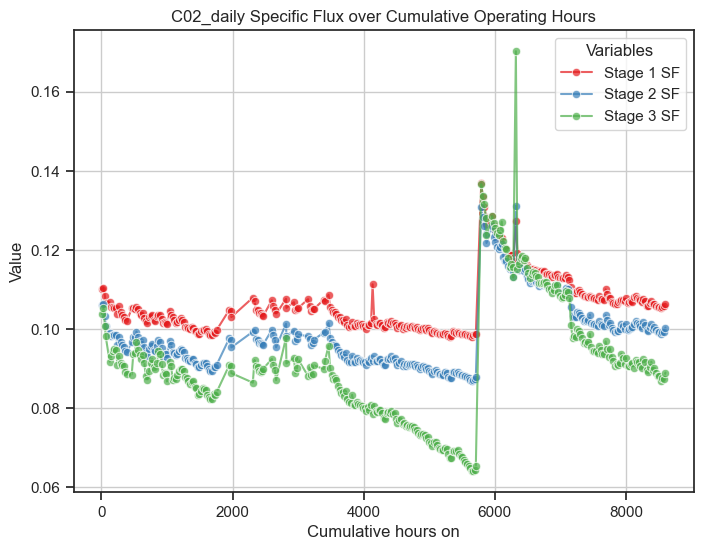

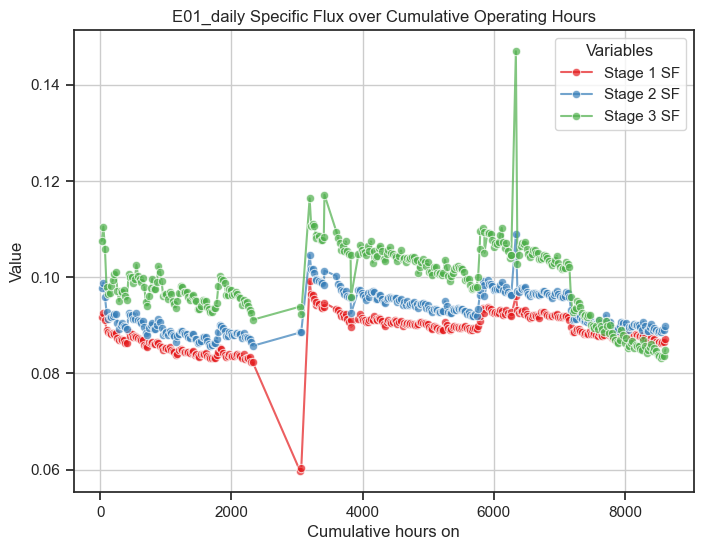

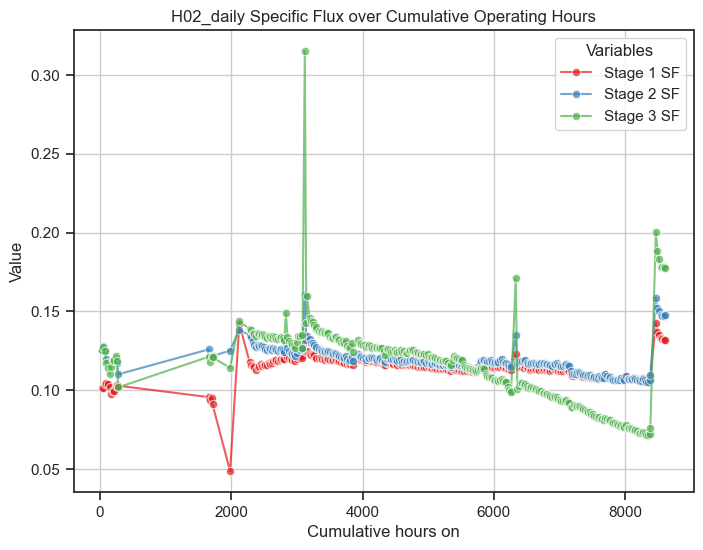

In [180]:
for i in SPI_filtered_df.keys():
    test = SPI_filtered_df[i][['Cumulative Hours On']+ ['Stage 1 SF', 'Stage 2 SF', 'Stage 3 SF']]
    plot_multiple_y(test, 'Cumulative Hours On', ['Stage 1 SF', 'Stage 2 SF', 'Stage 3 SF'])
    plt.title(i+' Specific Flux over Cumulative Operating Hours')
    plt.show()

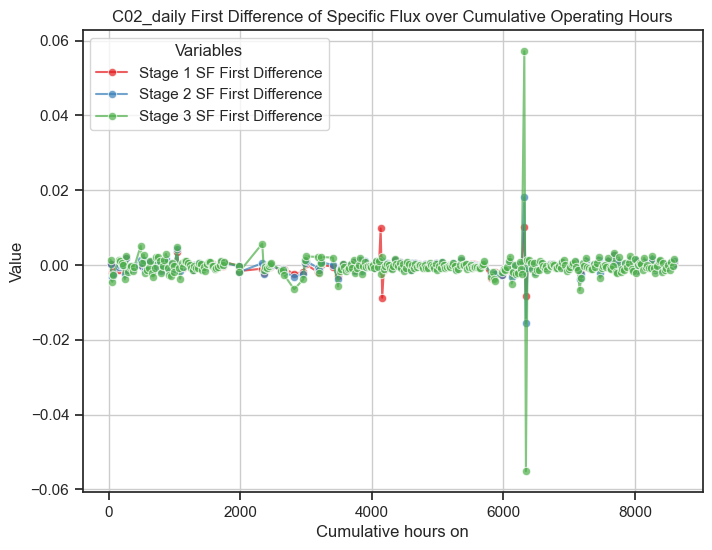

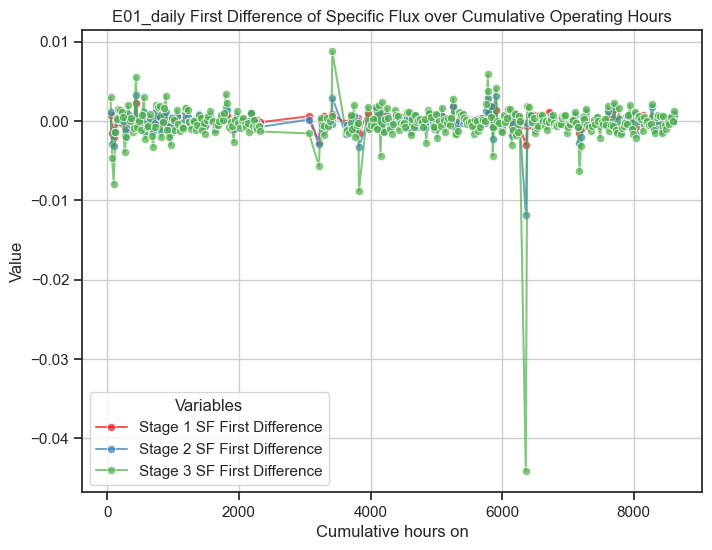

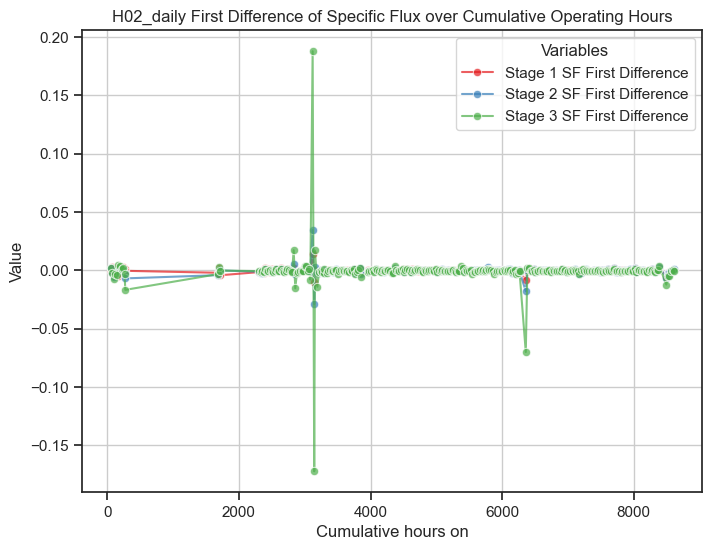

In [181]:
xcol=['Stage 1 SF First Difference', 'Stage 2 SF First Difference', 'Stage 3 SF First Difference']
for i in SPI_filtered_df.keys():
    test = SPI_filtered_df[i][['Cumulative Hours On']+ xcol]  
    plot_multiple_y(test, 'Cumulative Hours On', xcol)
    plt.title(i+' First Difference of Specific Flux over Cumulative Operating Hours')
    plt.show()